# Why Are Our Customers Churning?

### Quick Reference
I. Project Plan  
II. Acquire and Split Data  
III. Create a Baseline Model with Decision Tree   
IV. Explore Data
V. Create and Compare Different Models
VI. Predict on Test Model using Ω Model
VII. Exporting Predictions and Probabilities to CSV

## I. Project Plan

### Summary

Zach, my team leader @ Telco Corp, wants to find out why our customers churning.  

Below is a list of questions he wants answers to: _tk, theres a new question from Maggie_

1. Are there features that indicate a higher propensity to churn? like type of internet service, type of phone service, online security and backup, senior citizens, paying more than x% of customers with the same services, etc.?
2. Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point? If so, what is that point for what service(s)?
3. If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?

### Goals

The goals of the project are to answer the questions above and to deliver the following data products:

1. Report detailing my analysis in an .ipynb format
2. CSV file containing my predictions on a test data set
3. Google Slides explaining my chosen model
4. .py files that are used through the entire pipeline, and that contains _reproducible_ python scripts
5. Read Me file on a github repo containing all files created for this project
  
### Data Dictionary for Encoded Attributes used in Modelling
|Encoded Attribute 	| Description 	| Legend 	|
|---------	|-------------	|-------	|
|prod_online_bs       |Merged online back-up and security |0: Has neither, 1:Has atleast one, 2: Has both       	|
|prod_stream         |Merged streaming tv and movies |0: Streams neither, 1:Streams either 2: Streams both                 	|
|prod_tech         	|From tech support             	|0: No tech support, 1: Has tech support                 	|
|prod_device         |From device protection             	|0: No device protection, 1: Has device protection                 	|       	|
|prod_paperless        |From paperless billing             	|0: Not paperless billing, 1: Paperless billing                 	|       	|
|contract_type_id      |Originally encoded contract types             	|0: Month-to-Month, 1: 1-year, 2:2-year                 	|       	|
|internet_service_type_id |Originally encoded internet service types   |0:DSL, 1:Fiber Optic, 2: None                 	|       	|
|payment_type_id     |Originally encoded payment types             	|0:Electronic check, 1:Mailed check, 2: Bank transfer, 3:Credit card                 	|       	|
|senior_citizen     |Originally encoded senior, non-senior distinction   	|0:Non-senior, 1:Senior                 	|       	|
|seg_household     |Merged from partner and dependents             	|0:Single-member, 1:Two-member, 2: More-than-two-member           	|
|monthly_charges  |Originally encoded monthly charges             	|Float type dollar amount                 	|       	|
|tenure         	|Originally encoded tenure, in total months of subscription with company             	|Integer type in months                  	|
|enc_churn         	|Encoded from churn             	|0:Stayed, 1:Churned                 	|

### Packages

In [294]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_profiling
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

import wrangle
import prep
import model
import explore

from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz, DecisionTreeClassifier
import graphviz
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

from scipy.stats import binom

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import RobustScaler

## I: Acquire and Split Data

Using the `get_sql_telcochurn` function from `wrangle.py`, acquire data from `telco_churn` database on MySQL.

In [3]:
telco = wrangle.get_sql_telco()

Split data to train and test, and set aside test data.

In [4]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customer_id                 7043 non-null object
gender                      7043 non-null object
senior_citizen              7043 non-null int64
partner                     7043 non-null object
dependents                  7043 non-null object
tenure                      7043 non-null int64
phone_service               7043 non-null object
multiple_lines              7043 non-null object
internet_service_type_id    7043 non-null int64
online_security             7043 non-null object
online_backup               7043 non-null object
device_protection           7043 non-null object
tech_support                7043 non-null object
streaming_tv                7043 non-null object
streaming_movies            7043 non-null object
contract_type_id            7043 non-null int64
paperless_billing           7043 non-null object
payment_type_id             7043 non-null int64
monthly_charges 

In [5]:
telco = telco.replace(" ",np.nan)
telco.isnull().sum()

customer_id                  0
gender                       0
senior_citizen               0
partner                      0
dependents                   0
tenure                       0
phone_service                0
multiple_lines               0
internet_service_type_id     0
online_security              0
online_backup                0
device_protection            0
tech_support                 0
streaming_tv                 0
streaming_movies             0
contract_type_id             0
paperless_billing            0
payment_type_id              0
monthly_charges              0
total_charges               11
churn                        0
dtype: int64

`total_charges` is an object type. There are 11 observations in the dataset that are encoded as empty. These observations are making the `total_charges` attribute an object instead of a float type.

With the quantity of our total data set (7043) and the time alloted for the project, I could afford losing 11 observations to facilitate analysis. Therefore, I am dropping all the nulls hereon.

>Action Steps:  
 >- Drop NaNs using `dropna()`
 >- Cast `total_charges` values to a float data type

In [6]:
telco = telco.dropna()
telco.total_charges = telco.total_charges.astype("float")

print(f"""
From the original train count of 7043, telco now has a {len(telco)} observations. Also, total charges is now a "{telco.total_charges.dtype}" data type.
""")


From the original train count of 7043, telco now has a 7032 observations. Also, total charges is now a "float64" data type.



### Split Test and Train Data

In [7]:
train, test = train_test_split(telco, train_size=0.7, random_state=123)

print(f"""
Train data size: {len(train)}
Test data size: {len(test)}
""")


Train data size: 4922
Test data size: 2110



## III. Create a Baseline Model with Decision Tree

Because Decision Tree accepts discrete and continuous features, I will create baseline model using a Decision Tree.  
> Action Steps:
> - Encode `churn` into a computer-readable variable with 0s and 1s values, such that 0 = No (Stayed), 1 = Yes (Churned). Use `int_encode` function from `prep`
   

In [9]:
train["enc_churn"] = train.churn.apply(prep.yes_no_to_boolean)

In [10]:
X_train=train[["senior_citizen","tenure","internet_service_type_id","contract_type_id","payment_type_id","monthly_charges"]]
y_train=train.enc_churn

### Create a baseline model using Decision Tree

Using `model_by_cart` function from `model.py`, create a decision tree model using all variables with numeric data as features (X), and the encoded churn variable `train.enc_churn` as the target variable (y).

In [11]:
yhat_trainb, yhat_trainb_proba, dt = model.model_by_cart(X_train,y_train,"entropy",3)

In [12]:
print(f"""
Baseline Predictions:
{yhat_trainb}
  
Probabilities of Baseline Predictions:
{yhat_trainb_proba}
""")


Baseline Predictions:
[0 0 0 ... 0 0 0]
  
Probabilities of Baseline Predictions:
[[0.80952381 0.19047619]
 [0.55687204 0.44312796]
 [0.55687204 0.44312796]
 ...
 [0.60187668 0.39812332]
 [0.95333333 0.04666667]
 [0.80952381 0.19047619]]



In [13]:
trainb_accuracy = dt.score(X_train, y_train)
print(trainb_accuracy)

0.7870784234051199


In [14]:
labels = ["stayed","churned"]
trainb_conf = pd.DataFrame(confusion_matrix(y_train, yhat_trainb), index=labels, columns=labels)
trainb_conf

,stayed,churned
stayed,3343,267
churned,781,531


In [15]:
trainb_report = classification_report(y_train, yhat_trainb)
print(trainb_report)

              precision    recall  f1-score   support

           0       0.81      0.93      0.86      3610
           1       0.67      0.40      0.50      1312

    accuracy                           0.79      4922
   macro avg       0.74      0.67      0.68      4922
weighted avg       0.77      0.79      0.77      4922



![baseline_decision_tree](baseline_dtb.jpg)

This is the code to produce the above decision tree diagram.
>dot_data = export_graphviz(dt, out_file=None)  
>graph = graphviz.Source(dot_data)  
>graph.render('telco_dtb', view=True)

## IV. Exploration

There are two underlying reasons why we ask the question - why are our customers churning:
 - Churn is a consumer behavior. So we want to understand the consumers that drive this behavior.
 - Of those consumers who churned, what made them cease their subscription, in other words, what are their motivations for leaving?
  
  
With the above in mind, these are the steps that I will undertake in data exploration:
1. Add features that encompass the consumer segments in the data. Doing so will help us understand WHO are churning.
    - Male
    - Female
    - Senior
    - Non-senior
    - Single household
    - Multiple household
    
2. Run a Chi-square test to see if the correlations between these segments and the act of churning are statistically significant.

3. Proceed to explore the segments, adding the product dimension. Now, we are able to understand WHO AND WHAT makes them likely to churn to round up our understanding of Churning as a Consumer Behavior.
    - phone service/multiple lines
    - internet service
    - online backup and security
    - streaming
    - tech support
    - billing method
    - payment method
    - charges
    - tenure

#### Add Features (Consumer Segment)

In [16]:
train["seg_gender"] = prep.order_encode(train[["gender"]],["Male","Female"])
train["seg_household"] = prep.order_encode(train[["dependents"]],["No","Yes"]) + prep.order_encode(train[["partner"]],["No","Yes"])

In [17]:
train.sample(10)

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,...,streaming_movies,contract_type_id,paperless_billing,payment_type_id,monthly_charges,total_charges,churn,enc_churn,seg_gender,seg_household
316,0468-YRPXN,Male,0,No,No,29,Yes,No,2,No,...,Yes,1,Yes,4,98.80,2807.10,No,0,0,0
5117,7197-VOJMM,Male,0,Yes,No,67,Yes,No,1,Yes,...,Yes,3,Yes,4,69.20,4671.65,No,0,0,1
6861,9746-YKGXB,Male,0,Yes,Yes,52,No,No phone service,1,Yes,...,Yes,2,No,3,44.25,2276.10,No,0,0,2
3010,4307-KWMXE,Male,0,No,No,10,No,No phone service,1,No,...,No,1,No,1,35.75,389.80,No,0,0,0
1381,2041-JIJCI,Female,0,No,No,5,Yes,Yes,1,No,...,Yes,1,Yes,1,64.00,370.25,No,0,1,0
604,0885-HMGPY,Male,0,No,No,62,Yes,Yes,1,Yes,...,No,3,No,3,69.40,4237.50,No,0,0,0
5280,7449-HVPIV,Male,0,Yes,Yes,55,Yes,Yes,2,No,...,No,1,Yes,4,90.40,5099.15,No,0,0,2
2290,3274-NSDWE,Female,0,No,No,68,Yes,No,3,No internet service,...,No internet service,3,No,4,19.60,1441.65,No,0,1,0
390,0577-WHMEV,Female,0,Yes,No,16,Yes,Yes,2,Yes,...,No,1,No,1,90.70,1374.90,No,0,1,1
1676,2446-PLQVO,Male,0,No,No,1,Yes,No,2,No,...,No,1,Yes,1,70.30,70.30,Yes,1,0,0


#### Run Chi-Square Tests for Each Segments

1. Chi2-Test for Senior and Non-senior

In [18]:
observed_senior = pd.crosstab(train.senior_citizen, train.enc_churn)
observed_senior

enc_churn,0,1
senior_citizen,,
0,3168,968
1,442,344


In [19]:
chi2, p_senior, degf, expected_senior = stats.chi2_contingency(observed_senior)

print(expected_senior)
print(f"p-val: {p_senior}")

[[3033.51483137 1102.48516863]
 [ 576.48516863  209.51483137]]
p-val: 4.34850778895587e-32


> **Takeaways:**
1. p-value is less than $\alpha\$. Therefore, senior as a segment is statistically significant.
2. There's a 64% increase in the number of seniors who churned, from expected to observed. This is huge compared to the other variant rates that are between 4-23%.

2. Chi2-Test for Male and Female

In [20]:
gender_matrix = pd.crosstab(train.seg_gender, train.enc_churn, normalize=True)
gender_matrix

enc_churn,0,1
seg_gender,,
0,0.369565,0.132466
1,0.363876,0.134092


> **Takeaways:**  
p-value is less than $\alpha\$. But looking at the proportion of churning vs gender, rates seem comparable. So I will not explore the gender segment further as there are no compelling patterns. I recommend creating a Cramer's V function to test for the strength of correlation for gender to validate my assumption.

2. Chi2-Test for Household Size (0: Single-member, 1: Two-member, 2: More than 2-member)

In [21]:
observed_household = pd.crosstab(train.seg_household, train.enc_churn)
observed_household

enc_churn,0,1
seg_household,,
0,1517,796
1,1025,338
2,1068,178


In [22]:
chi2, p_household, degf, expected_household = stats.chi2_contingency(observed_household)

print(expected_household)
print(f"p-val: {p_household}")

[[1696.45062983  616.54937017]
 [ 999.68102397  363.31897603]
 [ 913.8683462   332.1316538 ]]
p-val: 6.872527458841416e-38


> **Takeaways:**
1. p-value is less than $\alpha\$. Therefore, senior as a segment is statistically significant.
2. There's a 46% decrease in the number of actual churn of more-than-2-household-size group compared to expected. This is a relatively huge variant rates compared to the others. What has made this group stay?
3. There's 29% increase in churn rate from the single-member-household group from what was expected to what was observed. This is not a huge number, but it would be interesting to look at this group further.

#### Add Features (Products)

In [24]:
train["prod_phone_service"] = prep.order_encode(train[["multiple_lines"]],["No phone service","No","Yes"])

train["prod_online_bs"] = (prep.order_encode(train[["online_security"]],["No internet service","No","Yes"])) - (prep.order_encode(train[["online_backup"]],["Yes","No","No internet service"]))
train.prod_online_bs = train.prod_online_bs.replace(-2,0)

train["prod_stream"] = (prep.order_encode(train[["streaming_tv"]],["No internet service","No","Yes"])) - (prep.order_encode(train[["streaming_movies"]],["Yes","No","No internet service"]))
train.prod_stream = train.prod_stream.replace(-2,0)

train["prod_tech"] = (prep.order_encode(train[["tech_support"]],["No internet service","No","Yes"]))

train["prod_device"] = (prep.order_encode(train[["device_protection"]],["No internet service","No","Yes"]))

train["prod_paperless"] = (prep.order_encode(train[["paperless_billing"]],["No","Yes"]))

In [25]:
train_red = train.iloc[:,24:31]
train_red[["contract_type_id","internet_service_type_id","payment_type_id","senior_citizen","seg_household","monthly_charges","total_charges","tenure","churn","enc_churn"]] = train[["contract_type_id","internet_service_type_id","payment_type_id","senior_citizen","seg_household","monthly_charges","total_charges","tenure","churn","enc_churn"]]

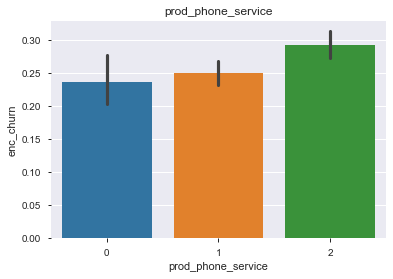

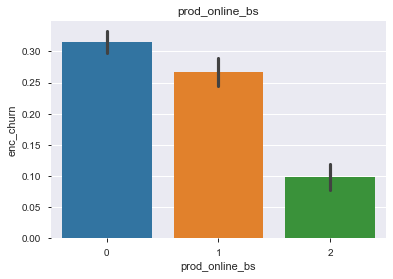

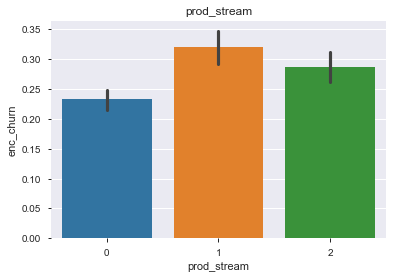

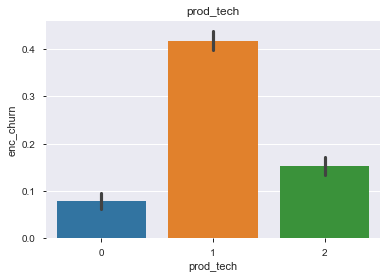

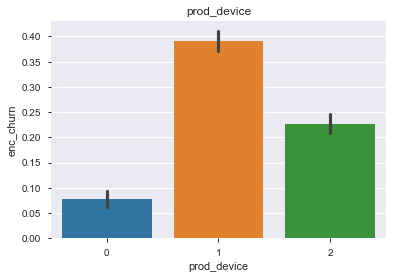

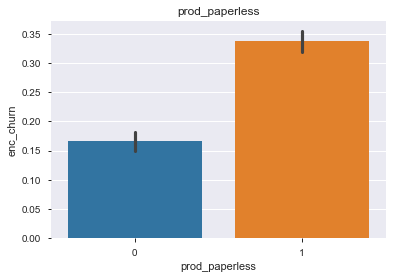

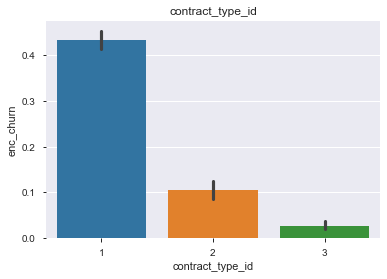

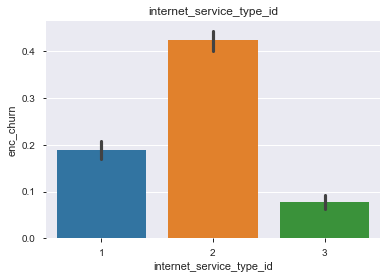

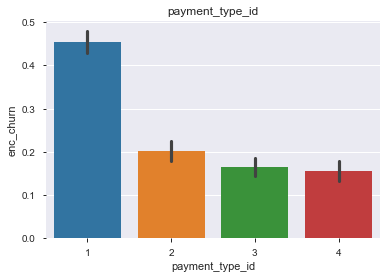

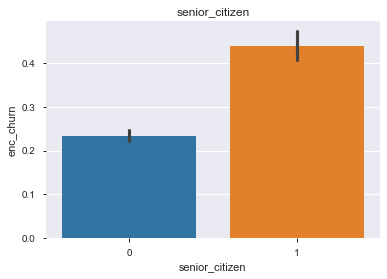

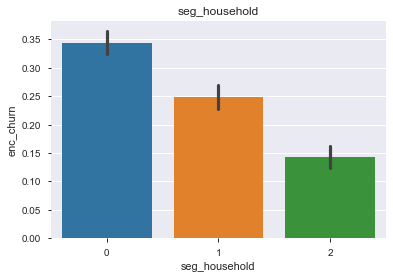

In [26]:
features = train_red.iloc[:,0:12].columns.tolist()
target = "enc_churn"

explore.plot_bars(features, target, train)

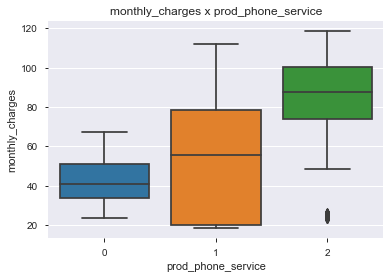

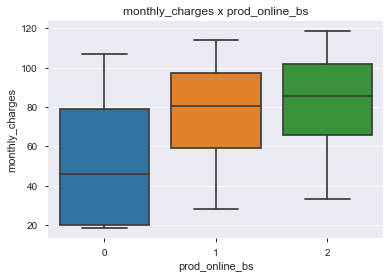

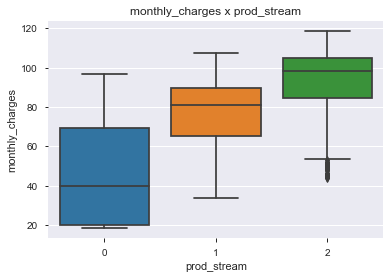

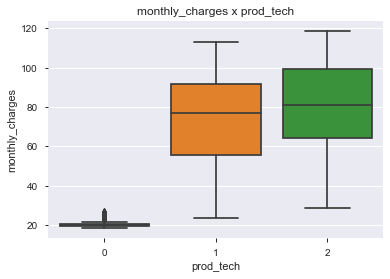

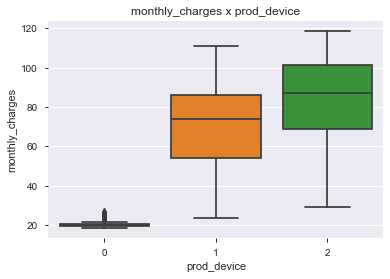

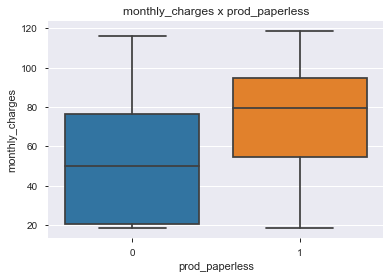

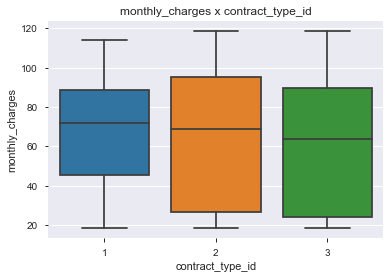

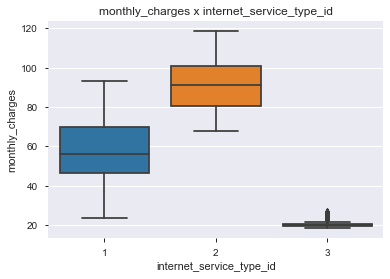

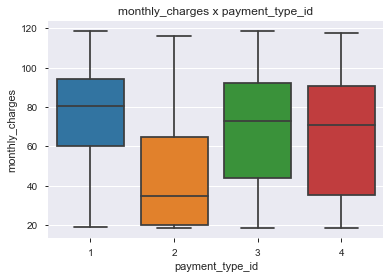

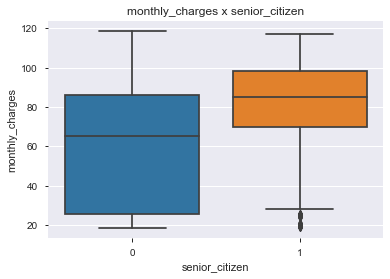

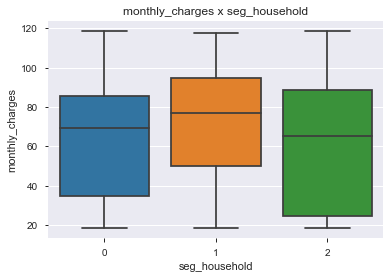

In [27]:
explore.plot_box(features,target,train)

In [132]:
train_red.groupby(["senior_citizen"])[["enc_churn","monthly_charges","tenure"]].mean()

,enc_churn,monthly_charges,tenure
senior_citizen,,,
0,0.234043,61.579219,32.156190
1,0.437659,79.965522,32.704835


Senior citizens only make up 16% of our train data, but 44% in their group are churning. They also have higher monthly charges compared to non-seniors (about \$20 more)
 - Maybe they have not upgraded and availed promos.
 - Not our target market but urge this population to upgrade to lessen monthly charges or create promos that lessen monthly charges by more or less \$20 to stop the bleeding.
 
*_Note: controlled for tech support, phone service, tech support, device protection, payment_type_id, paperless billing (55 vs 77%, not churn:churn), tenure. No rate/averages are compelling, hence my conclusion._

In [107]:
train_red.groupby(["seg_household","prod_phone_service"])[["enc_churn","monthly_charges"]].mean()

enc_churn  monthly_charges
seg_household prod_phone_service                            
0             0                    0.317181        39.893612
              1                    0.316996        54.100237
              2                    0.393423        81.607247
1             0                    0.220588        43.593382
              1                    0.220149        58.718377
              2                    0.274964        85.698480
2             0                    0.096491        45.440789
              1                    0.137124        49.629933
              2                    0.159176        77.853933

**Multiple-member household pay the least average monthly charges, and churn the least.**

In [108]:
train_red.groupby(["seg_household","contract_type_id"])[["enc_churn","monthly_charges"]].mean()

enc_churn  monthly_charges
seg_household contract_type_id                            
0             1                  0.466254        64.319907
              2                  0.088312        61.435195
              3                  0.028754        54.194888
1             1                  0.424699        71.079669
              2                  0.132308        71.928615
              3                  0.034759        69.640909
2             1                  0.319149        64.987589
              2                  0.099688        63.564330
              3                  0.021912        56.850697

Highest churn rate comes from these segments:  
**Single-member and two-member households who have month-to-month subscription.**

In [120]:
train_red.groupby(["contract_type_id","internet_service_type_id"])[["enc_churn","monthly_charges"]].mean()

enc_churn  monthly_charges
contract_type_id internet_service_type_id                            
1                1                          0.322917        50.177546
                 2                          0.557143        86.881701
                 3                          0.195652        20.363587
2                1                          0.087629        61.397680
                 2                          0.177378        98.608226
                 3                          0.023622        20.679528
3                1                          0.019523        70.583189
                 2                          0.067616       104.190214
                 3                          0.011186        21.770582

Highest churn rate are coming from month-to-month contracts that are subscribed to fiber optics. Fiber optics are relatively more expensive internet service ranging from an average of $ 86-104 in total monthly charges.  

Then again **56% of month-to-month/fiber optics subscribers are churning** compared to 18% and 7% of fiber optic subscribers who are on an annual and bi-annual contracts, respectively.
> **Takeaway:**
 - We're not offering bad fiber optics service. We just need to prolong the contracts of this population.

In [121]:
train_red.groupby(["seg_household","payment_type_id"])[["enc_churn","monthly_charges"]].mean()

enc_churn  monthly_charges
seg_household payment_type_id                            
0             1                 0.524130        73.549270
              2                 0.252912        43.650166
              3                 0.203390        66.181477
              4                 0.227941        62.237990
1             1                 0.425056        81.191163
              2                 0.178571        49.526563
              3                 0.181303        71.339235
              4                 0.129794        70.944690
2             1                 0.279152        75.515194
              2                 0.118812        41.424917
              3                 0.100295        64.102360
              4                 0.090343        64.734268

<div class="alert alert-block alert-info">
<b>Question:</b> Are there features that indicate a higher propensity to churn? like type of internet service, type of phone service, online security and backup, senior citizens, paying more than x% of customers with the same services, etc.?
</div>

**Answer:**

Yes. Below are the following features and descriptions:
1. seg_senior - Senior Citizens
2. seg_household - One-member household
3. prod_online_bs - Has atleast an online backup or security subscription
4. prod_tech - Has a tech support subscription
5. prod_device - Has a device protection
6. prod_paperless - Has subscribed to paperless billing
7. contract_type_id - Month-to-month contracts
8. internet_service_type_id - Fiber Optic
9. payment_type_id - Electronic checks

<div class="alert alert-block alert-info">
<b>Question:</b> Is there a price threshold for specific services where the likelihood of churn increases when the price for those services goes past that point? If so, what is that point for what service(s)?
</div>

**Answer:**  
At more than \$50 - Subscribers with single and multiple phone lines are more likely to churn

In [28]:
train["monthly_bins"] = pd.cut(train.monthly_charges,3)
train_red["monthly_bins"] = train.monthly_bins

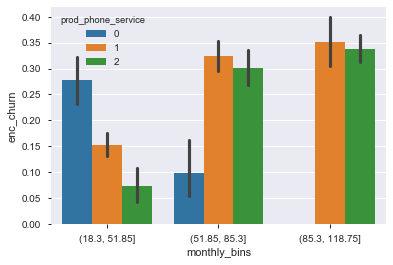

In [298]:
sns.barplot(x="monthly_bins", y="enc_churn", data=train_red, hue="prod_phone_service")

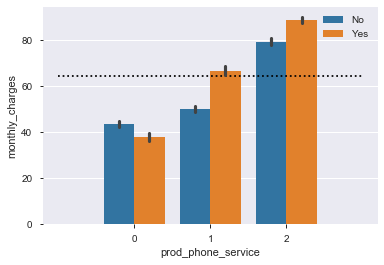

In [30]:
sns.barplot(x="prod_phone_service", y="monthly_charges",data=train_red,hue="churn")
plt.legend()
plt.hlines(y=train_red.monthly_charges.mean(), xmin=-1, xmax=3, ls=":")

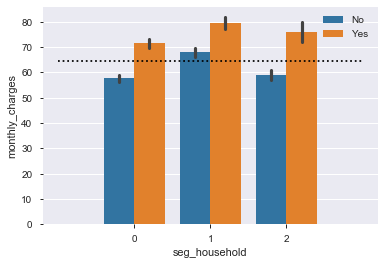

In [31]:
sns.barplot(x="seg_household", y="monthly_charges",data=train_red,hue="churn")
plt.legend()
plt.hlines(y=train_red.monthly_charges.mean(), xmin=-1, xmax=3, ls=":")

<div class="alert alert-block alert-info">
<b>Question:</b> If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?
</div>

**Answer:**  
After the 12-month period lapsed, 38.3% churned. Out of those, 37% are on a month-to-month contract while only 1% are on a one-year contract. The rates hugely vary.

In [32]:
twelve_months = train_red[train_red.tenure == 13]
pd.crosstab(twelve_months.churn, twelve_months.contract_type_id,normalize=True)

contract_type_id,1,2,3
churn,,,
No,0.423077,0.102564,0.089744
Yes,0.371795,0.012821,0.000000


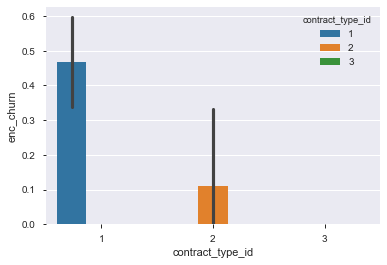

In [33]:
sns.barplot(y="enc_churn",x="contract_type_id", data=twelve_months, hue="contract_type_id")

#### TAKEAWAYS:

**Important Features to consider in my model:**
1. seg_senior
2. seg_household 
3. prod_online_bs 
4. prod_tech
5. prod_device
6. prod_paperless
7. contract_type_id
8. internet_service_type_id
9. payment_type_id
10. tenure
11. monthly_charges

## V. Create and Compare Different Models

In [34]:
X_trainm = train_red.drop(columns=["prod_phone_service","monthly_bins","churn","total_charges","enc_churn"])
y_trainm = train_red[["enc_churn"]]

In [46]:
robust_scaler = RobustScaler(quantile_range=(25.0,75.0), copy=True, with_centering=True, with_scaling=True).fit(X_trainm)
scaled_train = robust_scaler.transform(X_trainm)
scaled_train = pd.DataFrame(scaled_train, columns=X_trainm.columns).set_index([X_trainm.index])

In [201]:
dtm = DecisionTreeClassifier(criterion="entropy", max_depth=20, random_state=123)
dtm = dtm.fit(X_trainm,y_trainm)
yhat_trainm= dtm.predict(X_trainm)
yhat_trainm_proba = dtm.predict_proba(X_trainm)

In [243]:
yhat_trainm, yhat_trainm_proba, dtm = model.model_by_cart(X_trainm,y_trainm,"gini",4)

In [244]:
trainm_accuracy = dtm.score(X_trainm, y_trainm)
print(f"""
Decision Tree model accuracy ratio: {round(trainm_accuracy,3)}
""")


Decision Tree model accuracy ratio: 0.799



In [254]:
dtm_traincm = confusion_matrix(y_trainm,yhat_trainm)
print(dtm_traincm)
len(y_trainm)

[[3260  350]
 [ 641  671]]


4922

In [245]:
print("Classification Report for Decision Tree Model")
print(classification_report(y_trainm, yhat_trainm))

Classification Report for Decision Tree Model
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      3610
           1       0.66      0.51      0.58      1312

    accuracy                           0.80      4922
   macro avg       0.75      0.71      0.72      4922
weighted avg       0.79      0.80      0.79      4922



![model_decision_tree](model_dtm.jpg)

In [262]:
X_trainm["predictions"] = pd.DataFrame(yhat_trainm)
X_trainm[["stay_proba","churn_proba"]] = pd.DataFrame(yhat_trainm_proba)

**K Nearest Neighbor Model**

In [140]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform',metric="cosine")
knn.fit(X_trainm, y_trainm)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='cosine',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [92]:
yhat_train_knn = knn.predict(X_trainm)

In [150]:
knn_acc = knn.score(X_trainm, y_trainm)
print(f"""
KNN model accuracy ratio: {round(knn_acc,3)}
""")


KNN model accuracy ratio: 0.837



In [141]:
print("Classification Report for KNN Model")
print(classification_report(y_train, yhat_train_knn))

Classification Report for KNN Model
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      3610
           1       0.72      0.63      0.67      1312

    accuracy                           0.84      4922
   macro avg       0.80      0.77      0.78      4922
weighted avg       0.83      0.84      0.83      4922



**Log Regression**

In [136]:
logit = LogisticRegression(C=1, class_weight={1:2}, random_state = 123, solver='saga')
logit.fit(scaled_train, y_trainm)
yhat_train_log = logit.predict(scaled_train)

In [135]:
logit_report = classification_report(y_train, yhat_train_log)
print(logit_report)

              precision    recall  f1-score   support

           0       0.89      0.78      0.83      3610
           1       0.55      0.73      0.63      1312

    accuracy                           0.77      4922
   macro avg       0.72      0.76      0.73      4922
weighted avg       0.80      0.77      0.78      4922



## VI. Predict on Test Model using Ω Model

Accuracy of Decision Tree and KNN model both registered at 84%.  

I choose Decision Tree to be the Ω Model because apart from a higher accuracy, it generally has higher precision and recall.

**Encode test data to mimic train.**

In [153]:
test["enc_churn"] = test.churn.apply(prep.yes_no_to_boolean)

test["seg_gender"] = prep.order_encode(test[["gender"]],["Male","Female"])
test["seg_household"] = prep.order_encode(test[["dependents"]],["No","Yes"]) + prep.order_encode(test[["partner"]],["No","Yes"])

test["prod_phone_service"] = prep.order_encode(test[["multiple_lines"]],["No phone service","No","Yes"])

test["prod_online_bs"] = (prep.order_encode(test[["online_security"]],["No internet service","No","Yes"])) - (prep.order_encode(test[["online_backup"]],["Yes","No","No internet service"]))
test.prod_online_bs = test.prod_online_bs.replace(-2,0)

test["prod_stream"] = (prep.order_encode(test[["streaming_tv"]],["No internet service","No","Yes"])) - (prep.order_encode(test[["streaming_movies"]],["Yes","No","No internet service"]))
test.prod_stream = test.prod_stream.replace(-2,0)

test["prod_tech"] = (prep.order_encode(test[["tech_support"]],["No internet service","No","Yes"]))

test["prod_device"] = (prep.order_encode(test[["device_protection"]],["No internet service","No","Yes"]))

test["prod_paperless"] = (prep.order_encode(test[["paperless_billing"]],["No","Yes"]))

In [173]:
test.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,online_security,...,churn,enc_churn,seg_gender,seg_household,prod_phone_service,prod_online_bs,prod_stream,prod_tech,prod_device,prod_paperless
6830,9701-CDXHR,Female,0,Yes,No,51,Yes,No,2,No,...,No,0,1,1,1,0,0,1,1,0
364,0533-UCAAU,Male,1,Yes,No,57,Yes,Yes,1,No,...,No,0,0,1,2,1,1,1,2,1
2066,2972-YDYUW,Female,0,No,No,57,Yes,Yes,2,No,...,No,0,1,0,2,1,1,2,1,0
6964,9881-VCZEP,Female,0,Yes,No,25,Yes,Yes,1,No,...,No,0,1,1,2,1,0,1,1,0
4870,6861-OKBCE,Female,0,No,Yes,11,Yes,No,3,No internet service,...,Yes,1,1,1,1,0,0,0,0,0


In [177]:
X_test = test[["prod_online_bs", "prod_stream","prod_tech","prod_device","prod_paperless","contract_type_id","internet_service_type_id","payment_type_id","senior_citizen","seg_household","monthly_charges","tenure"]]
y_test = test[["enc_churn"]]

In [237]:
yhat_testm= dtm.predict(X_test)
yhat_testm_proba = dtm.predict_proba(X_test)

In [238]:
testm_accuracy = dtm.score(X_test, y_test)
print(f"""
Decision Tree model accuracy ratio: {round(testm_accuracy,3)}
""")


Decision Tree model accuracy ratio: 0.788



In [253]:
dtm_testcm = confusion_matrix(y_test,yhat_testm)
print(dtm_testcm)
print(len(y_test))

[[1399  154]
 [ 294  263]]
2110


In [239]:
print("Classification Report for Decision Tree Model")
print(classification_report(y_tes`t, yhat_testm))

Classification Report for Decision Tree Model
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1553
           1       0.63      0.47      0.54       557

    accuracy                           0.79      2110
   macro avg       0.73      0.69      0.70      2110
weighted avg       0.77      0.79      0.78      2110



## VII. Exporting Predictions and Probabilities to CSV

In [283]:
X_test["predictions"] = pd.DataFrame(yhat_testm)
X_test[["stay_proba","churn_proba"]] = pd.DataFrame(yhat_testm_proba)

In [284]:
churn_prediction = pd.concat([X_trainm, X_test])
churn_prediction = churn_prediction[["predictions","stay_proba","churn_proba"]]

In [285]:
churn_prediction = telco.join(churn_prediction)

In [287]:
churn_predictions = churn_prediction[["customer_id","predictions","stay_proba","churn_proba"]]
churn_predictions.to_csv(r'telcochurn_probability_and_predictions.csv')